# Variational Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('data/fashion', one_hot=True)
n_samples = mnist.train.num_examples

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


## Task: fill the gaps in VAE 

In [76]:
class VAE:

    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        self._create_network()
        self._create_loss_optimizer()

        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = self._recognition_network()

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        # tip: use tf.random_normal
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq))

        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self._generator_network()

    def _recognition_network(self):
        layer_1 = slim.fully_connected(self.x, self.network_architecture['n_hidden_recog_1'],  activation_fn=tf.nn.relu)
        layer_2 = slim.fully_connected(layer_1, self.network_architecture['n_hidden_recog_2'],  activation_fn=tf.nn.relu)

        z_mean = slim.fully_connected(layer_2, self.network_architecture['n_z'],  activation_fn=None)
        z_log_sigma_sq = slim.fully_connected(layer_2, self.network_architecture['n_z'])

        return z_mean, z_log_sigma_sq

    def _generator_network(self):
        layer_1 = slim.fully_connected(self.z, self.network_architecture['n_hidden_recog_1'],  activation_fn=tf.nn.relu)
        layer_2 = slim.fully_connected(layer_1, self.network_architecture['n_hidden_recog_2'],  activation_fn=tf.nn.relu)
        x_reconstr_mean = slim.fully_connected(layer_2, self.network_architecture['n_input'],  activation_fn=None)

        return x_reconstr_mean

    def _create_loss_optimizer(self):

        reconstr_loss = tf.reduce_sum((self.x - self.x_reconstr_mean)**2, 1) 

        dist_z = tf.distributions.Normal(loc=self.z_mean, scale=tf.sqrt(tf.exp(self.z_log_sigma_sq)))
        dist_norm = tf.distributions.Normal(loc=0., scale=1.)
        
        latent_loss = tf.reduce_sum(tf.distributions.kl_divergence(dist_z, dist_norm), 1)

        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


In [77]:
def train(network_architecture, learning_rate=0.001,
          batch_size=1000, training_epochs=10, display_step=5):
    vae = VAE(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Visualize reconstruction quality

In [78]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z = 20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=179)

Epoch: 0001 cost= 65.126121105
Epoch: 0006 cost= 36.747374448
Epoch: 0011 cost= 34.928047527
Epoch: 0016 cost= 34.279412703
Epoch: 0021 cost= 33.803273565
Epoch: 0026 cost= 33.466895155
Epoch: 0031 cost= 33.355319838
Epoch: 0036 cost= 33.195234056
Epoch: 0041 cost= 32.971478480
Epoch: 0046 cost= 32.772201157
Epoch: 0051 cost= 32.674392839
Epoch: 0056 cost= 32.557073246
Epoch: 0061 cost= 32.548517955
Epoch: 0066 cost= 32.519706587
Epoch: 0071 cost= 32.441556306
Epoch: 0076 cost= 32.275326642
Epoch: 0081 cost= 32.275329625
Epoch: 0086 cost= 32.160099411
Epoch: 0091 cost= 32.125397942
Epoch: 0096 cost= 32.117084954
Epoch: 0101 cost= 32.071786464
Epoch: 0106 cost= 32.035273361
Epoch: 0111 cost= 32.015517009
Epoch: 0116 cost= 31.963001771
Epoch: 0121 cost= 31.983597322
Epoch: 0126 cost= 31.888338054
Epoch: 0131 cost= 31.852220847
Epoch: 0136 cost= 31.808881274
Epoch: 0141 cost= 31.725954957
Epoch: 0146 cost= 31.888881267
Epoch: 0151 cost= 31.725167153
Epoch: 0156 cost= 31.731564296
Epoch: 0

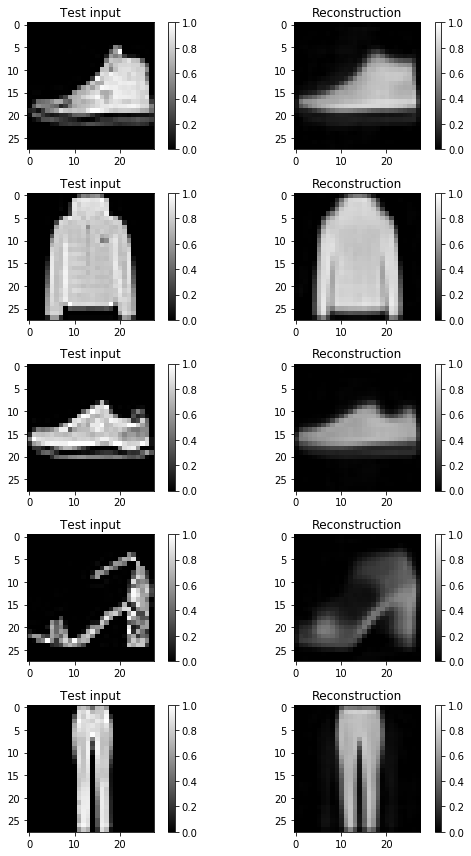

In [81]:
x_sample = mnist.test.next_batch(1000)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [82]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=179)

Epoch: 0001 cost= 65.694362294
Epoch: 0006 cost= 41.650053406
Epoch: 0011 cost= 41.078952928
Epoch: 0016 cost= 40.860684204
Epoch: 0021 cost= 40.631224060
Epoch: 0026 cost= 40.637435081
Epoch: 0031 cost= 40.588940499
Epoch: 0036 cost= 40.459099509
Epoch: 0041 cost= 40.546891160
Epoch: 0046 cost= 40.499240667
Epoch: 0051 cost= 40.395328591
Epoch: 0056 cost= 40.514640045
Epoch: 0061 cost= 40.425671040
Epoch: 0066 cost= 40.360258345
Epoch: 0071 cost= 40.354953488
Epoch: 0076 cost= 40.352415674
Epoch: 0081 cost= 40.451873155
Epoch: 0086 cost= 40.312720004
Epoch: 0091 cost= 40.310854270
Epoch: 0096 cost= 40.408197715
Epoch: 0101 cost= 40.191601008
Epoch: 0106 cost= 40.386329651
Epoch: 0111 cost= 40.270838512
Epoch: 0116 cost= 40.176751848
Epoch: 0121 cost= 40.342730158
Epoch: 0126 cost= 40.243451344
Epoch: 0131 cost= 40.239171392
Epoch: 0136 cost= 40.191692768
Epoch: 0141 cost= 40.193017578
Epoch: 0146 cost= 40.312157024
Epoch: 0151 cost= 40.250841938
Epoch: 0156 cost= 40.240576241
Epoch: 0

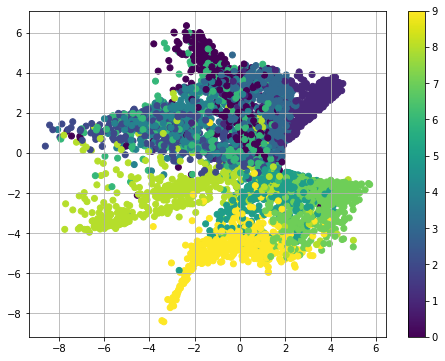

In [83]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

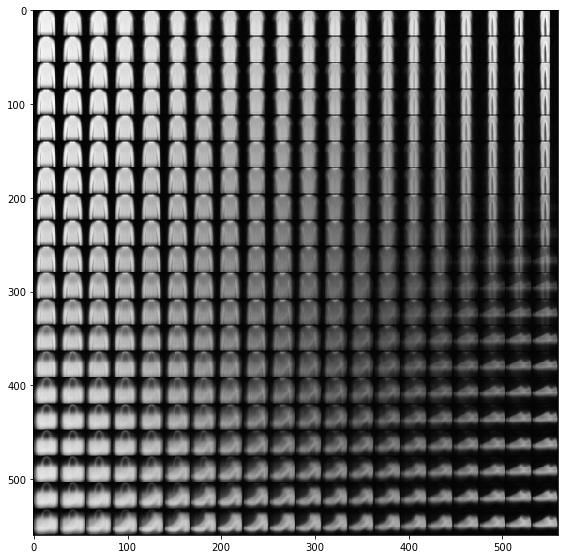

In [84]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()